In [8]:
# Install missing dependencies
%pip install pyspark
%pip install delta-spark
%pip install matplotlib
%pip install seaborn


import os
import sys
from delta.pip_utils import configure_spark_with_delta_pip
from pyspark.sql import SparkSession

import sys
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


# Build spark session
builder = SparkSession.builder \
    .master("local[*]") \
    .appName("DataAnalysis") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12-2.4.0")
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Define Parameters
ROOT_PATH = "C:\\Users\\Asus\\OneDrive\\RugbyIntelligence\\"
LAKEHOUSE_PATH = os.path.join(ROOT_PATH, 'lakehouse')
SILVER_PATH = os.path.join(LAKEHOUSE_PATH, 'silver')
SILVER_GAME_PATH = os.path.join(SILVER_PATH, 'game')
SILVER_GAME_STAT_PATH = os.path.join(SILVER_PATH, 'game_stat')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Prepare Silver Data

In [9]:
from IPython.display import display
df_game = spark.read.format('delta').load(SILVER_GAME_PATH)
pdf_game = df_game.where(
    "home_team = 'South Africa' or away_team = 'South Africa'").toPandas()


df_game_stat = spark.read.format('delta').load(SILVER_GAME_STAT_PATH)
pdf_game_stat = df_game_stat.toPandas()

merged_pdf = pdf_game.merge(pdf_game_stat, on='game_key', how='inner')

merged_pdf['team'] = merged_pdf.apply(
    lambda row: row['home_team'] if row['team'] == 'Home' else row['away_team'], axis=1)

clean_merged_pdf = merged_pdf.drop_duplicates()



Historical Match Analysis: South Africa vs New Zealand

In [10]:
filtered_data_nz = clean_merged_pdf[
    ((clean_merged_pdf['home_team'] == 'South Africa') & (clean_merged_pdf['away_team'] == 'New Zealand')) |
    ((clean_merged_pdf['home_team'] == 'New Zealand') &
     (clean_merged_pdf['away_team'] == 'South Africa'))
]
filtered_data_nz = filtered_data_nz[filtered_data_nz['datetime'] >= '2021-01-01']

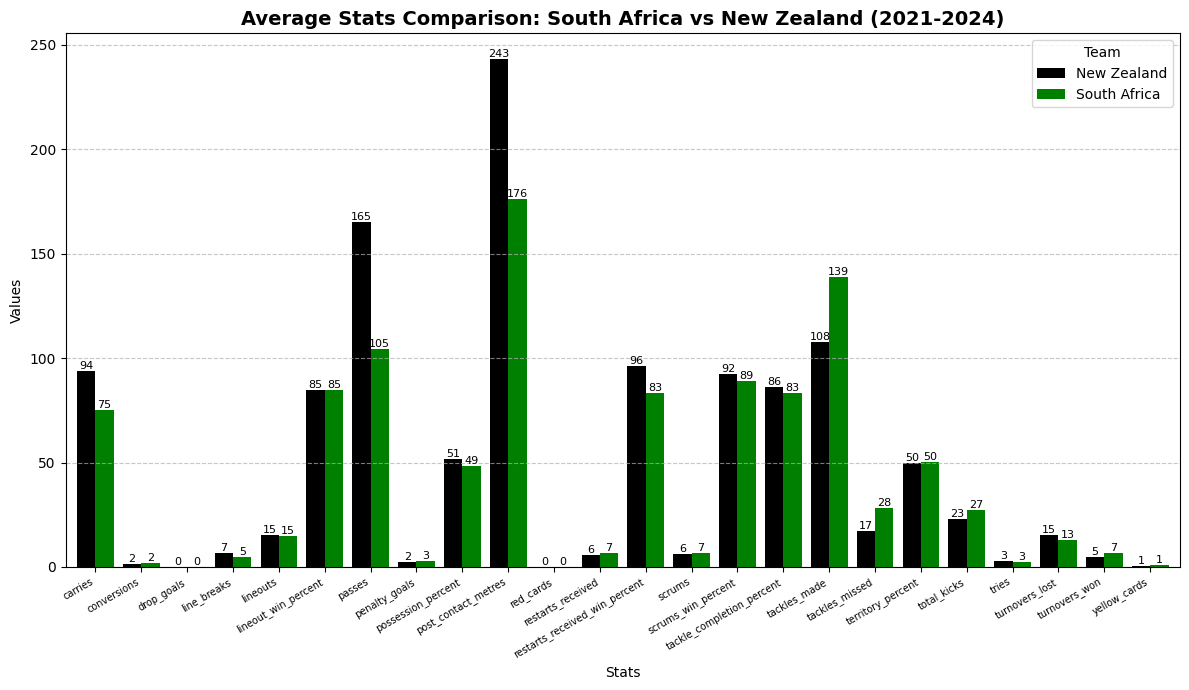

In [11]:
import matplotlib.pyplot as plt

# Filter data for matches between South Africa and New Zealand
filtered_data_nz = clean_merged_pdf[
    ((clean_merged_pdf['home_team'] == 'South Africa') & (clean_merged_pdf['away_team'] == 'New Zealand')) |
    ((clean_merged_pdf['home_team'] == 'New Zealand') &
     (clean_merged_pdf['away_team'] == 'South Africa'))
]

# Select the stats to compare
colors = {'South Africa': 'green', 'New Zealand': 'black'}
stats = ['carries', 'conversions', 'drop_goals', 
       'line_breaks', 'lineouts', 'lineout_win_percent', 'passes',
       'penalty_goals', 'possession_percent', 'post_contact_metres',
       'red_cards', 'restarts_received', 'restarts_received_win_percent',
       'scrums', 'scrums_win_percent', 'tackle_completion_percent',
       'tackles_made', 'tackles_missed', 'territory_percent', 'total_kicks',
       'tries', 'turnovers_lost', 'turnovers_won', 'yellow_cards']

# Prepare data for plotting
team_stats_nz = filtered_data_nz.groupby('team')[stats].mean()

# # Plot the bar chart
ax = team_stats_nz.T.plot(kind='bar', figsize=(12, 7), color=[colors.get(
    team, 'blue') for team in team_stats_nz.index], width=0.8)
plt.title('Average Stats Comparison: South Africa vs New Zealand (2021-2024)',
          fontsize=14, fontweight='bold')
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom margin to give more space for x-axis labels
plt.ylabel('Values')
plt.xlabel('Stats')
plt.xticks(rotation=30, ha='right', fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Team', loc='upper right')

# Add data labels with reduced font size
for container in ax.containers:
    ax.bar_label(container, fmt='%.f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()


# Prepare data for the pie chart
win_counts = filtered_data_nz['result'].value_counts()

# Map results to teams
win_counts_mapped = {
    'South Africa': win_counts.get('South Africa', 0),
    'New Zealand': win_counts.get('New Zealand', 0)
}


Kicks vs Territory Correlation

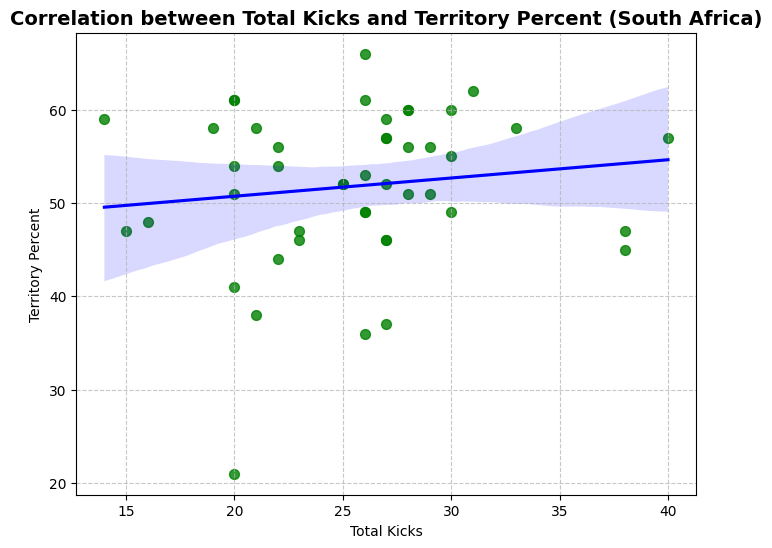

In [12]:
import seaborn as sns

# Install seaborn if not already installed
# Filter the data for team = 'South Africa'
south_africa_data = clean_merged_pdf[clean_merged_pdf['team'] == 'South Africa']

# Plot the correlation between total_kicks and territory_percent
plt.figure(figsize=(8, 6))
sns.regplot(data=south_africa_data, x='total_kicks', y='territory_percent', color='green', scatter_kws={'s': 50}, line_kws={'color': 'blue'})
plt.title('Correlation between Total Kicks and Territory Percent (South Africa)', fontsize=14, fontweight='bold')
plt.xlabel('Total Kicks')
plt.ylabel('Territory Percent')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Tackles made vs Completion %

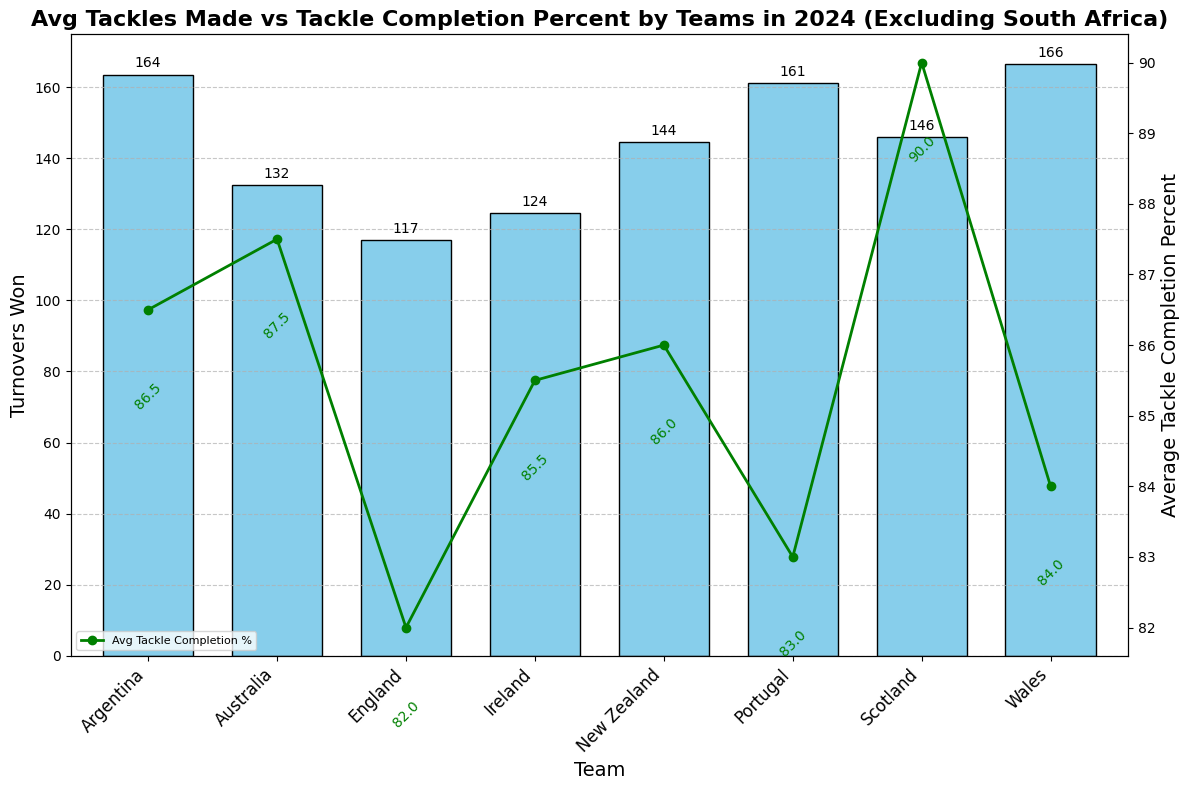

In [13]:
# Filter the data for matches in 2024 excluding South Africa
clean_merged_pdf_non_sa = clean_merged_pdf[clean_merged_pdf['team'] != 'South Africa']
turnovers_data_2024 = clean_merged_pdf_non_sa[clean_merged_pdf_non_sa['datetime'].dt.year == 2024].groupby('team')[['tackles_made', 'tackle_completion_percent']].mean()

# Create a bar chart for turnovers_won
fig, ax1 = plt.subplots(figsize=(12, 8))
turnovers_data_2024['tackles_made'].plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', width=0.7)

# Customize the bar chart
ax1.set_title('Avg Tackles Made vs Tackle Completion Percent by Teams in 2024 (Excluding South Africa)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Team', fontsize=14)
ax1.set_ylabel('Turnovers Won', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticks(range(len(turnovers_data_2024.index)))
ax1.set_xticklabels(turnovers_data_2024.index, rotation=45, ha='right', fontsize=12)

# Add data labels for the bar chart
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.f', label_type='edge', fontsize=10, padding=3)

# Create a secondary axis for tackle_completion_percent
ax2 = ax1.twinx()
ax2.plot(turnovers_data_2024.index, turnovers_data_2024['tackle_completion_percent'], color='green', marker='o', linewidth=2, label='Avg Tackle Completion %')

# Add data labels for the line chart with adjusted positioning
for i, value in enumerate(turnovers_data_2024['tackle_completion_percent']):
    ax2.text(i, value - 1, f'{value:.1f}', ha='center', va='top', fontsize=10, color='green', rotation=45)
ax2.set_ylabel('Average Tackle Completion Percent', fontsize=14)
ax2.legend(loc='lower left', fontsize=8)

plt.tight_layout()
plt.show()


Stat Correlation Heatmap

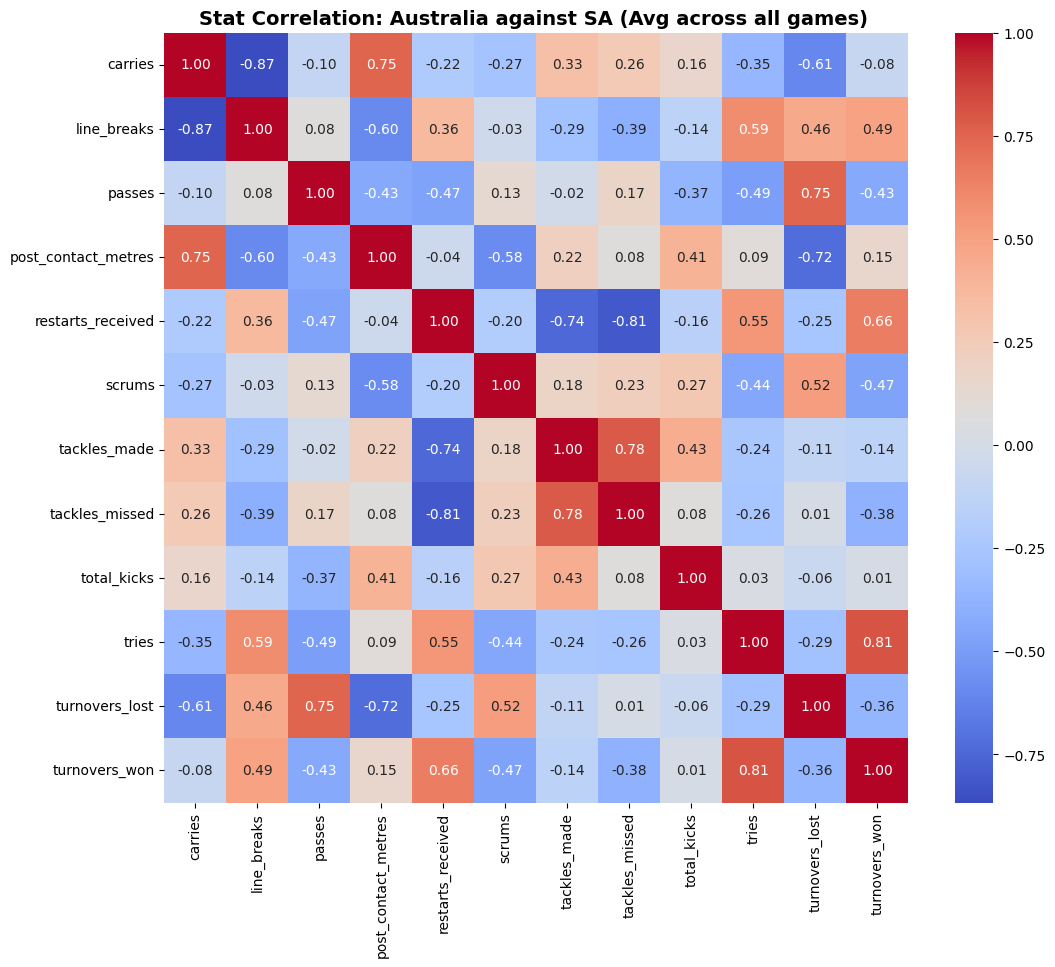

In [14]:
import seaborn as sns

filtered_data_aus_sa = clean_merged_pdf[
    (((clean_merged_pdf['home_team'] == 'South Africa') & (clean_merged_pdf['away_team'] == 'Australia')) |
    ((clean_merged_pdf['home_team'] == 'Australia') & (clean_merged_pdf['away_team'] == 'South Africa'))) &
    (clean_merged_pdf['team'] == 'Australia')

]

stats_columns = ['carries', 'line_breaks',
                  'passes', 'post_contact_metres',  'restarts_received', 
                  'scrums','tackles_made', 'tackles_missed', 
                  'total_kicks', 'tries', 'turnovers_lost', 
                 'turnovers_won', ]


heatmap_data = filtered_data_aus_sa[stats_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Stat Correlation: Australia against SA (Avg across all games) ', fontsize=14, fontweight='bold')
plt.show()